# Assessing how the number of pregnancies and miscarriages influences menstrual cycle regularity and fertility indicators.

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset
data = pd.read_csv('FedCycleData.csv')

# Convert relevant columns to numeric, treating non-numeric entries as missing values
columns_to_convert = ['Numberpreg', 'Miscarriages', 'MeanCycleLength']
for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Fill missing values with the median
for column in columns_to_convert:
    data[column].fillna(data[column].median(), inplace=True)

# Create a binary target variable for cycle regularity
# Assuming 'MeanCycleLength' of 25-35 days as regular
data['CycleRegularity'] = data['MeanCycleLength'].apply(lambda x: 1 if 25 <= x <= 35 else 0)


C:\Users\nehli\AppData\Local\Temp\ipykernel_2828\1787752977.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)


In [21]:
# Selecting features and defining the target
X = data[['Numberpreg', 'Miscarriages']]  # Include more features as needed
y = data['CycleRegularity']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:
# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [23]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using classification report, confusion matrix, and accuracy score
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00       499

    accuracy                           1.00       500
   macro avg       0.50      0.50      0.50       500
weighted avg       1.00      1.00      1.00       500

Confusion Matrix:
 [[  0   1]
 [  0 499]]
Accuracy: 0.998


c:\Users\nehli\anaconda3\envs\myenv1\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nehli\anaconda3\envs\myenv1\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nehli\anaconda3\envs\myenv1\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
from sklearn.utils import resample

# Balancing the dataset using oversampling the minority class
majority = data[data.CycleRegularity == 1]
minority = data[data.CycleRegularity == 0]

minority_upsampled = resample(minority,
                              replace=True,     # sample with replacement
                              n_samples=len(majority),    # to match majority class
                              random_state=42)   # reproducible results

# Combine the majority class with upsampled minority class
upsampled = pd.concat([majority, minority_upsampled])

# New split
X_upsampled = upsampled[['Numberpreg', 'Miscarriages']]
y_upsampled = upsampled['CycleRegularity']
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_upsampled, y_upsampled, test_size=0.3, random_state=42)

# Model with balanced class weight
model_balanced = LogisticRegression(class_weight='balanced')
model_balanced.fit(X_train_up, y_train_up)
y_pred_up = model_balanced.predict(X_test_up)

# Evaluate the model again
print("Classification Report:\n", classification_report(y_test_up, y_pred_up))
print("Confusion Matrix:\n", confusion_matrix(y_test_up, y_pred_up))
print("Accuracy:", accuracy_score(y_test_up, y_pred_up))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.61      0.74       472
           1       0.73      0.95      0.83       523

    accuracy                           0.79       995
   macro avg       0.82      0.78      0.78       995
weighted avg       0.82      0.79      0.78       995

Confusion Matrix:
 [[290 182]
 [ 26 497]]
Accuracy: 0.7909547738693468


In [25]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(model_balanced, X_upsampled, y_upsampled, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation scores: [0.77677225 0.78280543 0.78883861 0.77526395 0.81268882]
Mean accuracy: 0.7872738126159132


In [26]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), parameters, cv=5)
grid_search.fit(X_upsampled, y_upsampled)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'C': 0.1}
Best cross-validation score: 0.79


In [27]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model with the optimal C value
optimized_model = LogisticRegression(C=0.1, class_weight='balanced')
optimized_model.fit(X_upsampled, y_upsampled)


LogisticRegression(C=0.1, class_weight='balanced')

In [29]:
# Evaluate the optimized model on the existing test set
y_pred_test = optimized_model.predict(X_test)

print("Final Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))


Final Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.03      1.00      0.07         1
           1       1.00      0.94      0.97       499

    accuracy                           0.94       500
   macro avg       0.52      0.97      0.52       500
weighted avg       1.00      0.94      0.97       500

Confusion Matrix:
 [[  1   0]
 [ 28 471]]
Accuracy: 0.944


In [30]:
from sklearn.model_selection import train_test_split

# Assuming you have already defined 'X_upsampled' and 'y_upsampled'
# Splitting into initial train/test sets
X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(X_upsampled, y_upsampled, test_size=0.1, random_state=42)

# Further splitting the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# Now, you train your model on X_train, validate on X_val, and finally test on X_test_final
model = LogisticRegression(C=0.1, class_weight='balanced')
model.fit(X_train, y_train)

# Final evaluation on X_test_final
y_pred_final = model.predict(X_test_final)

print("Final Model Evaluation on Held-out Test Set:")
print("Classification Report:\n", classification_report(y_test_final, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))


Final Model Evaluation on Held-out Test Set:
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.76       148
           1       0.77      0.97      0.86       184

    accuracy                           0.82       332
   macro avg       0.86      0.80      0.81       332
weighted avg       0.85      0.82      0.82       332

Confusion Matrix:
 [[ 94  54]
 [  5 179]]
Accuracy: 0.822289156626506


neural network

from sklearn.preprocessing import StandardScaler



In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_up)
X_test_scaled = scaler.transform(X_test_final)  # Using the same scaler to transform the test set


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the model
model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer + hidden layer with 10 neurons
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\nehli\anaconda3\envs\myenv1\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
history = model.fit(X_train_scaled, y_train_up, epochs=50, batch_size=10, validation_split=0.2)


Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.7009 - loss: 0.6841 - val_accuracy: 0.8319 - val_loss: 0.6054
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8920 - loss: 0.5950 - val_accuracy: 0.9095 - val_loss: 0.5326
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.9057 - loss: 0.5239 - val_accuracy: 0.9095 - val_loss: 0.4864
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.9023 - loss: 0.5091 - val_accuracy: 0.9095 - val_loss: 0.4579
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.9066 - loss: 0.4727 - val_accuracy: 0.9095 - val_loss: 0.4400
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.9162 - loss: 0.4501 - val_accuracy: 0.9095 - val_loss: 0.4254
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.9071 - loss: 0.4372 - val_accuracy: 0.9095 - val_loss: 0.4133
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8977 - loss: 0.4277 - 

In [34]:
loss, accuracy = model.evaluate(X_test_scaled, y_test_final)
print(f'Accuracy: {accuracy}')


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.9432 - loss: 0.2571
Accuracy: 0.9096385836601257


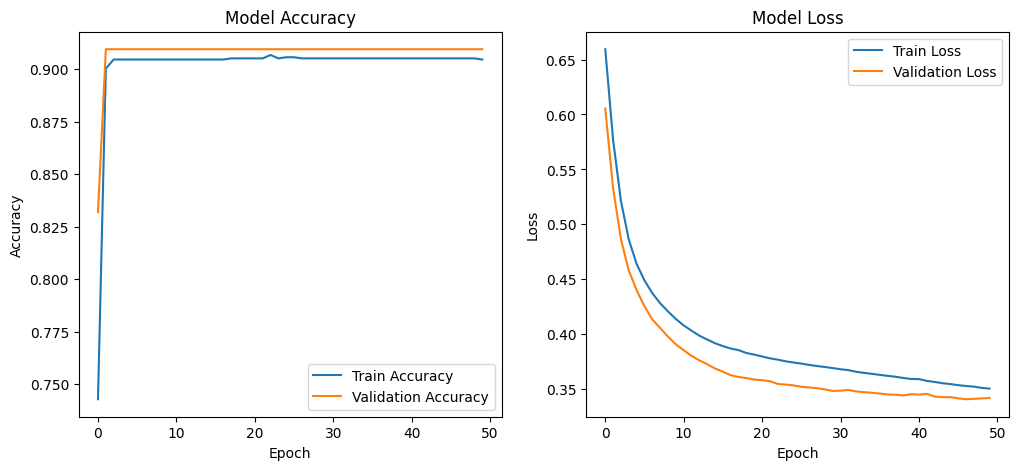

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
